<a href="https://colab.research.google.com/github/oecorrechag/neural-network-tensorflow/blob/main/notebooks/class%2028%20-%20transfer_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIMS

Ejemplo de red neuronal con transfer learning with tensorflow

https://www.tensorflow.org/hub/publish?hl=es-419

https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/5

https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1

https://tfhub.dev/google/collections/image/1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import string
import pandas as pd
import time
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"

## Cargar el train y test

In [4]:
# !wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip \
#     -O sign-language-img.zip

In [5]:
# Descomprimimos
local_zip = '/tmp/sign-language-img.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/sign-language-img')
zip_ref.close()

In [6]:
train_dir = "/tmp/sign-language-img/Train"
test_dir = "/tmp/sign-language-img/Test"

## Data Generators

In [7]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split= 0.2)

In [8]:
train_generator_resize = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "training"
)

validation_generator_resize = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "validation"
)

test_generator_resize = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb"
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


## Definir las clases

Recordar que hay dos letras que no tenemos J y Z

In [9]:
classes = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

## Generate model

In [10]:
model_hub = tf.keras.Sequential([
                                 tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
                                 hub.KerasLayer(module_url, trainable=False),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation ="relu"),
                                 tf.keras.layers.Dropout(rate=0.2),
                                 tf.keras.layers.Dense(len(classes), activation = "softmax")
])

model_hub.build((None, 150, 150, 3))
model_hub.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1343049   
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
Total params: 1,474,401
Trainable params: 131,352
Non-trainable params: 1,343,049
_________________________________________________________________


## Training

In [11]:
model_hub.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_hub = model_hub.fit(
    train_generator_resize,
    epochs= 5,
    validation_data = validation_generator_resize
)

Epoch 1/5
215/215 [==============================] - 41s 141ms/step - loss: 1.5775 - accuracy: 0.5084 - val_loss: 0.8779 - val_accuracy: 0.7004
Epoch 2/5
215/215 [==============================] - 28s 132ms/step - loss: 0.6856 - accuracy: 0.7722 - val_loss: 0.6148 - val_accuracy: 0.7796
Epoch 3/5
215/215 [==============================] - 28s 131ms/step - loss: 0.4839 - accuracy: 0.8404 - val_loss: 0.5112 - val_accuracy: 0.8232
Epoch 4/5
215/215 [==============================] - 29s 133ms/step - loss: 0.3740 - accuracy: 0.8765 - val_loss: 0.4666 - val_accuracy: 0.8358
Epoch 5/5
215/215 [==============================] - 33s 154ms/step - loss: 0.3145 - accuracy: 0.8951 - val_loss: 0.4253 - val_accuracy: 0.8421


## Testing

In [12]:
results = model_hub.evaluate(test_generator_resize)

57/57 [==============================] - 8s 135ms/step - loss: 0.4272 - accuracy: 0.8489


## Summary model

In [15]:
def visualizacion_resultados(history):
    epochs = [i for i in range(5)]
    fig, ax = plt.subplots(1,2)
    train_acc = history.history["accuracy"]
    train_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    fig.set_size_inches(16, 9)

    ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
    ax[0].plot(epochs, val_acc, "ro-", label= "Validacion accuracy")
    ax[0].set_title("Entrenamiento & validación accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
    ax[1].plot(epochs, val_loss, "ro-", label= "Validacion Loss")
    ax[1].set_title("Entrenamiento & validación Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.show()

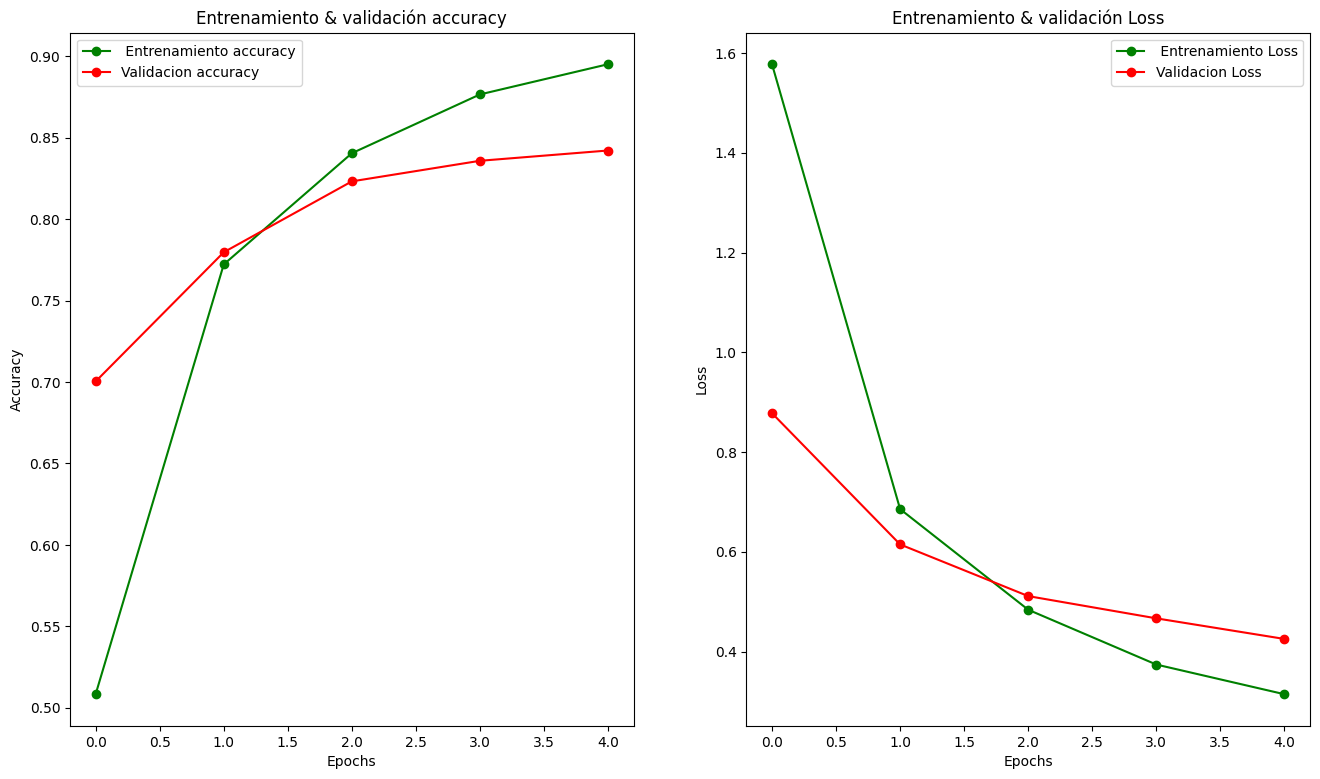

In [16]:
visualizacion_resultados(history_hub)

## Actividad 2

In [18]:
module_url2 = "https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1"

In [19]:
model_hub2 = tf.keras.Sequential([
                                 tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
                                 hub.KerasLayer(module_url2, trainable=False),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation ="relu"),
                                 tf.keras.layers.Dropout(rate=0.2),
                                 tf.keras.layers.Dense(len(classes), activation = "softmax")
])

model_hub2.build((None, 150, 150, 3))
model_hub2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1000)              25549352  
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 24)                3096      
                                                                 
Total params: 25,680,576
Trainable params: 131,224
Non-trainable params: 25,549,352
_________________________________________________________________


## Training

In [20]:
model_hub2.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_hub2 = model_hub2.fit(
    train_generator_resize,
    epochs= 5,
    validation_data = validation_generator_resize
)

Epoch 1/5
215/215 [==============================] - 109s 422ms/step - loss: 0.9833 - accuracy: 0.6855 - val_loss: 0.7143 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 88s 409ms/step - loss: 0.3836 - accuracy: 0.8727 - val_loss: 0.5359 - val_accuracy: 0.8161
Epoch 3/5
215/215 [==============================] - 87s 405ms/step - loss: 0.2701 - accuracy: 0.9107 - val_loss: 0.5134 - val_accuracy: 0.8330
Epoch 4/5
215/215 [==============================] - 87s 406ms/step - loss: 0.2119 - accuracy: 0.9290 - val_loss: 0.4502 - val_accuracy: 0.8470
Epoch 5/5
215/215 [==============================] - 87s 407ms/step - loss: 0.1773 - accuracy: 0.9416 - val_loss: 0.4378 - val_accuracy: 0.8561


## Testing

In [21]:
results2 = model_hub2.evaluate(test_generator_resize)

57/57 [==============================] - 22s 389ms/step - loss: 0.4267 - accuracy: 0.8604


## Summary model

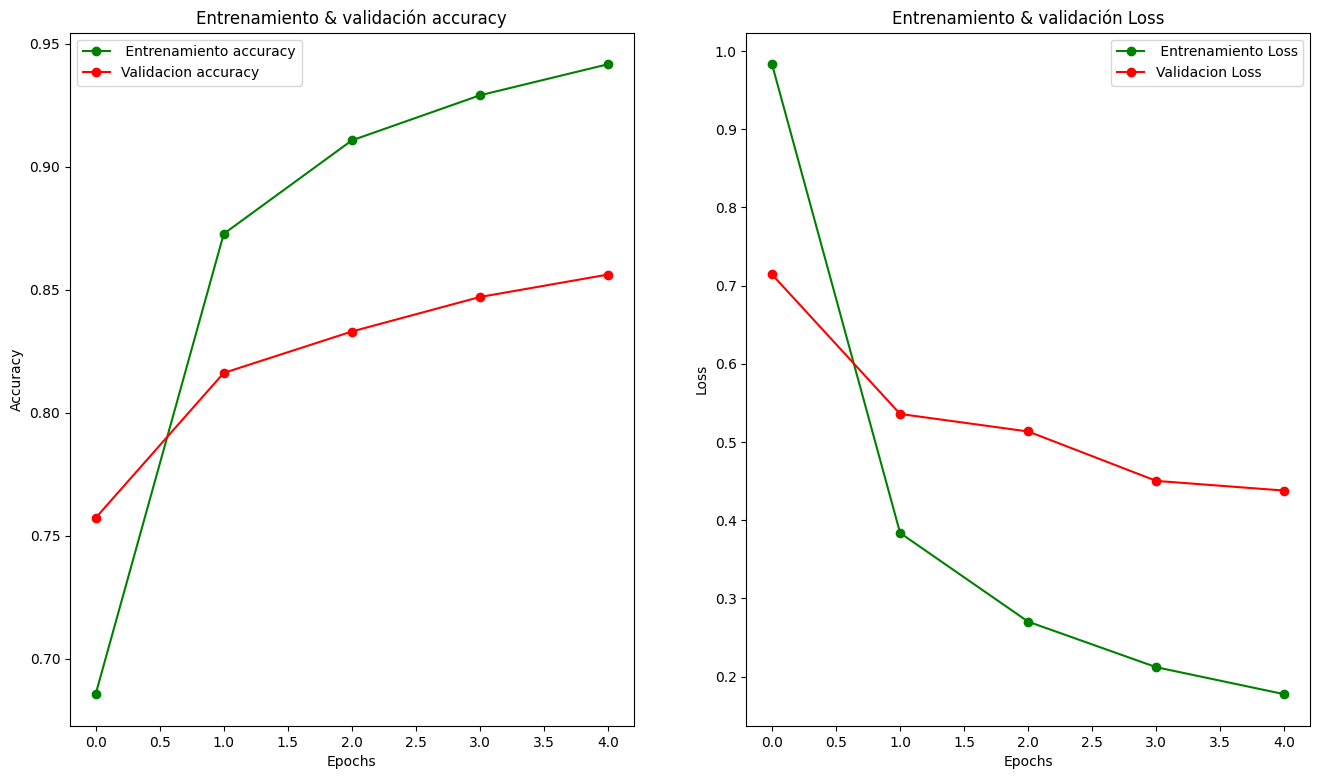

In [22]:
visualizacion_resultados(history_hub2)

In [17]:
print('Ok_')

Ok_
